## Установка зависимостей и подключение библиотек

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!unzip -q /content/gdrive/My\ Drive/av-photos.zip -d train
!cp /content/gdrive/My\ Drive/FN-EfficientNet_b18.tar last_model
!cp /content/gdrive/My\ Drive/acc_history.json acc_history.json

In [4]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Sep 22 18:43:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [5]:
import json
import pickle
import os
import time
import copy
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

DEVICE = torch.device("cuda")

## Сreate a dataset wrapper for convenient work

In [6]:
class CarDataset(Dataset):
    """
    A dataset with pictures, which parallel loads them from folders,
    scans and turns them into end tensors
    """
    def __init__(self, files):
        super().__init__()
        # file list for loading
        self.files = sorted(files)

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()
            
        # create label for image  
        self.labels = [ " ".join([path.parent.parent.name, path.parent.name]) for path in self.files]
        self.label_encoder.fit(self.labels)

        with open('label_encoder.pkl', 'wb') as le_dump_file:
              pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        # tarnsform image to pytorch tensor
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """
    Function for print image with their label
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

### Upload our files and do a little visualization

In [8]:
TRAIN_DIR = Path('train/av-photos')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

In [9]:
from sklearn.model_selection import train_test_split

train_val_labels = [ " ".join([path.parent.parent.name, path.parent.name]) for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, random_state=1)

In [10]:
val_dataset = CarDataset(val_files)
train_dataset = CarDataset(train_files)

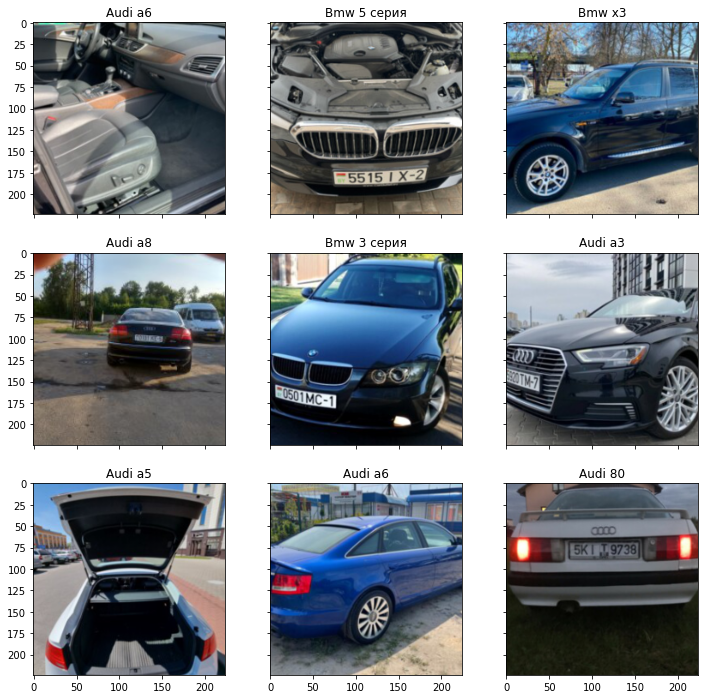

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Building a neural network
As a baseline, I will use the pre-trained EfficientNet with fine-tuning

In [12]:
BATCH_SIZE = 32
CLASS_NUM = len(set(train_val_labels))
NUM_EPOCHS = 6
feature_extract = True

In [13]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
efficientnet.classifier.fc = torch.nn.Linear(in_features=efficientnet.classifier.fc.in_features, out_features=CLASS_NUM)

chek = torch.load('last_model')
efficientnet.load_state_dict(chek['model_state_dict'])

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: p

  0%|          | 0.00/20.5M [00:00<?, ?B/s]

<All keys matched successfully>

In [14]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [15]:
# Send the model to GPU
model_ft = efficientnet.to(DEVICE)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft.load_state_dict(chek['optimizer_state_dict'])

Params to learn:
	 stem.conv.weight
	 stem.bn.weight
	 stem.bn.bias
	 layers.0.block0.depsep.conv.weight
	 layers.0.block0.depsep.bn.weight
	 layers.0.block0.depsep.bn.bias
	 layers.0.block0.se.squeeze.weight
	 layers.0.block0.se.squeeze.bias
	 layers.0.block0.se.expand.weight
	 layers.0.block0.se.expand.bias
	 layers.0.block0.proj.conv.weight
	 layers.0.block0.proj.bn.weight
	 layers.0.block0.proj.bn.bias
	 layers.1.block0.expand.conv.weight
	 layers.1.block0.expand.bn.weight
	 layers.1.block0.expand.bn.bias
	 layers.1.block0.depsep.conv.weight
	 layers.1.block0.depsep.bn.weight
	 layers.1.block0.depsep.bn.bias
	 layers.1.block0.se.squeeze.weight
	 layers.1.block0.se.squeeze.bias
	 layers.1.block0.se.expand.weight
	 layers.1.block0.se.expand.bias
	 layers.1.block0.proj.conv.weight
	 layers.1.block0.proj.bn.weight
	 layers.1.block0.proj.bn.bias
	 layers.1.block1.expand.conv.weight
	 layers.1.block1.expand.bn.weight
	 layers.1.block1.expand.bn.bias
	 layers.1.block1.depsep.conv.weight
	

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['val'] = val_loader

In [19]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_hist, train_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=NUM_EPOCHS)

Epoch 0/5
----------
train Loss: 0.8091 Acc: 0.7972
val Loss: 1.5003 Acc: 0.6535

Epoch 1/5
----------
train Loss: 0.7136 Acc: 0.8197
val Loss: 1.5010 Acc: 0.6589

Epoch 2/5
----------
train Loss: 0.6264 Acc: 0.8410
val Loss: 1.5283 Acc: 0.6592

Epoch 3/5
----------
train Loss: 0.5511 Acc: 0.8601
val Loss: 1.5524 Acc: 0.6623

Epoch 4/5
----------
train Loss: 0.4807 Acc: 0.8769
val Loss: 1.5731 Acc: 0.6604

Epoch 5/5
----------
train Loss: 0.4219 Acc: 0.8919
val Loss: 1.6192 Acc: 0.6628

Training complete in 186m 0s
Best val Acc: 0.662847


In [20]:
# torch.save({'model_state_dict': model_ft.state_dict(),
#             'optimizer_state_dict': optimizer_ft.state_dict()}, 'FN-EfficientNet_b18.tar')

# with open('acc_history.json', 'r') as f:
#     acc_history = json.load(f)

# acc_history.update({'val': acc_history['val']+[float(i) for i in val_hist]})
# acc_history.update({'train': acc_history['train']+[float(i) for i in train_hist]})

# # Save accuracy from this training loop
# with open('acc_history.json', 'w') as f:
#     json.dump(acc_history, f)

### Evaluating neural network
Calculate the value of f1-score, visualisate the confidence of our neural network and make accuracy plot of the model.

In [57]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [59]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [58]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [63]:
from sklearn.metrics import f1_score

f1_score_sample = []
for i in range(100):
    random_characters = int(np.random.uniform(0,1000))
    ex_img, true_label = val_dataset[random_characters]
    probs_im = predict_one_sample(model_ft, ex_img.unsqueeze(0))

    idxs = list(map(int, np.random.uniform(0,1000, 20)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model_ft, imgs)

    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]

    preds_class = [label_encoder.classes_[i] for i in y_pred]


    f1_score_sample.append(f1_score(actual_labels, y_pred, average='weighted'))

np.array(f1_score_sample).mean()

0.8036545478909464

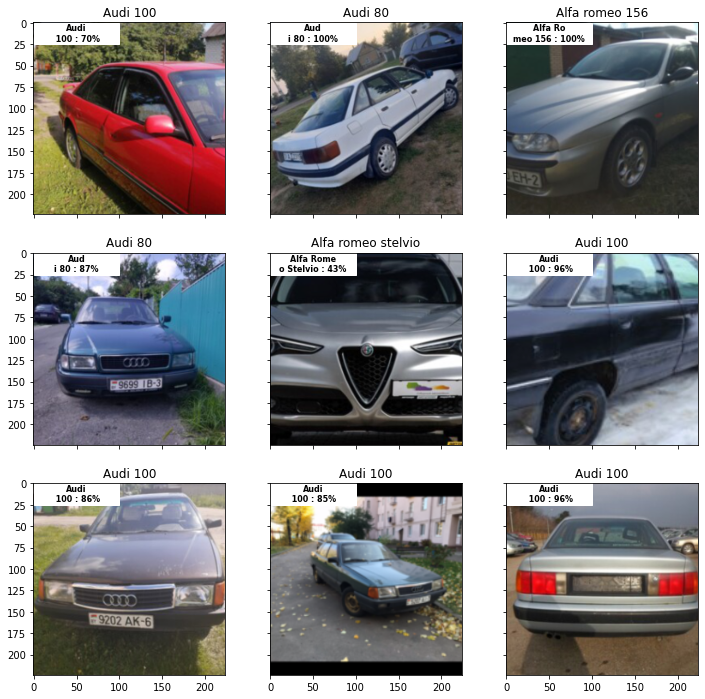

In [56]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 0),100,25,color='white'))
    font0 = FontProperties(size='x-large')
    font = font0.copy()
    prob_pred = predict_one_sample(model_ft, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(50, 1, predicted_text , horizontalalignment='center', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [17]:
with open('acc_history.json', 'r') as f:
    acc_history = json.load(f)

In [19]:
batches = [i for i in range(18)]
train = acc_history['train']
val = acc_history['val']

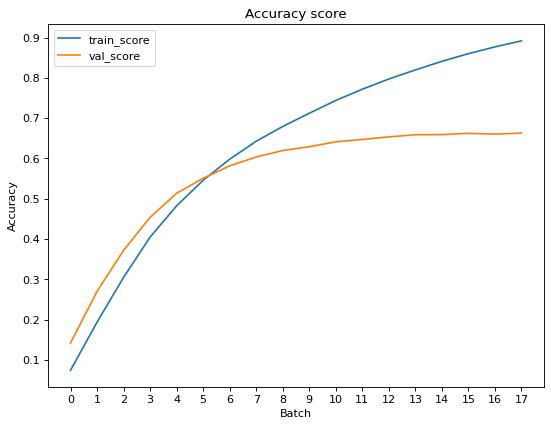

In [29]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(batches, train, label='train_score')
plt.plot(batches, val, label='val_score')
plt.xticks(np.arange(0, 18, 1))
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.title("Accuracy score")
plt.legend()
plt.show()